In [1]:
# Packages to load
using PyPlot, LinearAlgebra, SparseArrays, GSL, DifferentialEquations, Sundials, PyCall, LsqFit, Printf, Interpolations, DelimitedFiles, JLD2 

In [2]:
# Plotting parameters
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15
rcParams["legend.fontsize"] = "x-large"
rcParams["axes.labelsize"] = "x-large"
rcParams["axes.titlesize"] = "x-large"
rcParams["xtick.labelsize"] = "x-large"
rcParams["ytick.labelsize"] = "x-large"
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"
rcParams["figure.figsize"] = (6, 6);

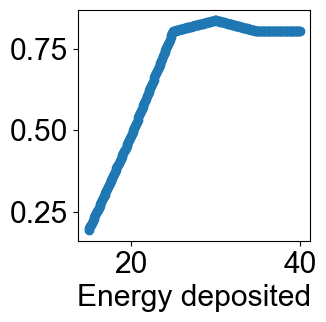

PyObject Text(0.5, 37.999999999999986, 'Energy deposited')

In [3]:
# Loading CASINO energy loss data
@load "./en_loss_data/ene_data.jld2" envals_kev ene_loss
figure(figsize=(3,3));
plot(envals_kev,ene_loss,linestyle="",marker="o"); xlabel("Energy deposited")

In [4]:
# Fitting energy loss function from CASINO data 
function ene_loss_ratio(ene_kev)
    res = zeros((length(ene_kev),))
    for i = 1:size(ene_kev,1);
        res[i] = ene_loss[argmin(abs.(ene_kev[i].-envals_kev))]
    end;
    return res
end;

In [5]:
y_unpat_curr = readdlm("exptdata/ratio_current_data_unpat.txt",',', Float64, '\n');
y_thick4_curr = readdlm("exptdata/ratio_current_data_thick4.txt",',', Float64, '\n');
y_unpat_curr = (y_unpat_curr[:,1], y_unpat_curr[:,2], y_unpat_curr[:,3]*1e6, y_unpat_curr[:,4]);
y_thick4_curr = (y_thick4_curr[:,1], y_thick4_curr[:,2], y_thick4_curr[:,3]*1e6, y_thick4_curr[:,4]);

In [6]:
y_unpat_volt = readdlm("exptdata/ratio_voltage_data_unpat.txt",',', Float64, '\n');
y_thick4_volt = readdlm("exptdata/ratio_voltage_data_thick4.txt",',', Float64, '\n');
y_unpat_volt = (y_unpat_volt[:,1], y_unpat_volt[:,2], y_unpat_volt[:,3]*1e6, y_unpat_volt[:,4]);
y_thick4_volt = (y_thick4_volt[2:end,1], y_thick4_volt[2:end,2], y_thick4_volt[2:end,3]*1e6, y_thick4_volt[2:end,4]);

In [7]:
# Create concatenated data sets:
x_unpat = vcat(y_unpat_curr[4].*y_unpat_curr[3].*ene_loss_ratio(y_unpat_curr[4]), y_unpat_volt[4].*y_unpat_volt[3].*ene_loss_ratio(y_unpat_volt[4]));
y_unpat = vcat(y_unpat_curr[1], y_unpat_volt[1]);
yerr_unpat = vcat(y_unpat_curr[2], y_unpat_volt[2]);

x_thick4 = vcat(y_thick4_curr[4].*y_thick4_curr[3].*ene_loss_ratio(y_thick4_curr[4]), y_thick4_volt[4].*y_thick4_volt[3].*ene_loss_ratio(y_thick4_volt[4]));
y_thick4 = vcat(y_thick4_curr[1], y_thick4_volt[1]);
yerr_thick4 = vcat(y_thick4_curr[2], y_thick4_volt[2]);

# Three-level model

In [8]:
## Rate Equations Model 
function rate_solve(du,u,p,t)
    Γ13 = p[1]; # Green to Excited
    Γ31 = p[2]; # Excited to Green
    Γ23 = p[3]; # Red to Excited
    Γ32 = p[4]; # Excited to Red 
    
    du[1] = -Γ13*u[1]*(1-u[3]) + Γ31*u[3]*(1-u[1]);
    du[2] = -Γ23*u[2]*(1-u[3]) + Γ32*u[3]*(1-u[2]);
    du[3] = Γ13*u[1]*(1-u[3]) - Γ31*u[3]*(1-u[1]) + Γ23*u[2]*(1-u[3]) - Γ32*u[3]*(1-u[2]);
end;

# Full data fit (voltage and current dependence)

In [9]:
function model(x, p, sol_flag = false)
    # x is power (in mW)
    ratio1 = p[1] # green to red
    scaling = p[2] # pump scaling
    scaling_ratio = p[3] # pump ratio (green to red)
    
    Γ32_0 = 1. # excited to red 
    Γ31_0 = Γ32_0*ratio1 # excited to green 
        
    emission_ratio = zeros(size(x,1))
    t_vec = 0.
    u_vec = 0.

    for ii = 1 : size(x,1);
        params = [scaling_ratio*scaling*x[ii], Γ31_0, scaling*x[ii], Γ32_0];

        u0 = zeros(3);
        u0[1] = 1.0;
        u0[2] = 1.0;        

        tspan = (0.0, 1e2);
        prob = ODEProblem(rate_solve, u0, tspan, params)

        sol = solve(prob, CVODE_BDF(), reltol=1e-6, abstol=1e-6);                

        emission_ratio[ii] = (params[2]*(1-sol.u[size(sol.t,1)][1])) / (params[4]*(1-sol.u[size(sol.t,1)][2]));
        
        t_vec = sol.t
        u_vec = sol.u
    end
    if sol_flag == false
        return emission_ratio
    else
        return emission_ratio, t_vec, u_vec
    end
end;

In [10]:
# Fitting unpatterned data
lb = [0.01, 0.00000001, 0.0001]
ub = [10., 0.1,100.]

p0_bounds = [0.026095468151660355, 0.0005110493031747057, 4.656893438297157]

wt = 1 ./ yerr_unpat

fit_bounds_unpat = curve_fit(model, x_unpat, y_unpat, p0_bounds, lower=lb, upper=ub)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.05841754419817247, 0.00010370469206241227, 4.433083368850169], [-0.22838833954628512, 0.39676471428624227, 0.6149093351943271, 0.13013374689973467, -0.016887127048827555, -0.3248294999399579, -0.679871318635606, -0.7303745531030286, -0.818867654717935, -0.07583459112481217, 0.11111685550805772, 1.226317504785885, 0.3590490310267431, -0.11920825389123069, -0.1088277061619789, -0.05411694650736232], [7.579019403427095 -2995.481707935999 0.15651261542021064; 10.016100722939703 -5125.873458789055 0.07731131766170402; … ; 8.190081576172046 -3487.319685480039 0.15927604221512284; 7.811159208687831 -3184.873470166097 0.4783722847755508], true, Float64[])

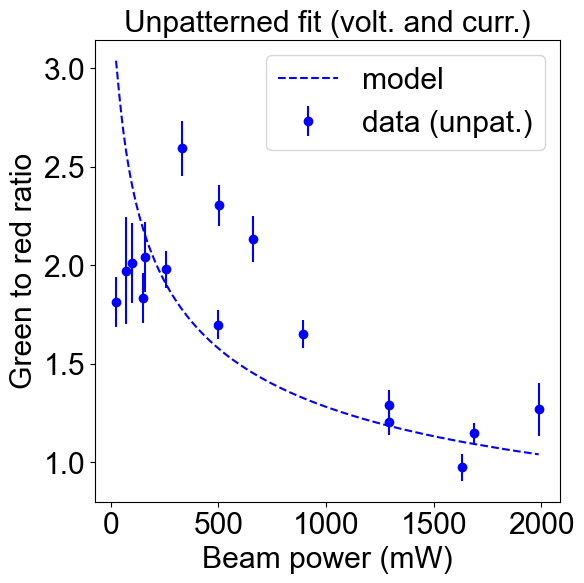

In [11]:
x_unpat_plot = [minimum(x_unpat):1.0:maximum(x_unpat);]
plot(sort(x_unpat_plot), model(sort(x_unpat_plot), fit_bounds_unpat.param), "--", label = "model", color = "blue")
errorbar(x_unpat, y_unpat, yerr = yerr_unpat, fmt = "o", label = "data (unpat.)", color = "blue");
legend()
xlabel("Beam power (mW)")
ylabel("Green to red ratio")
title("Unpatterned fit (volt. and curr.)");

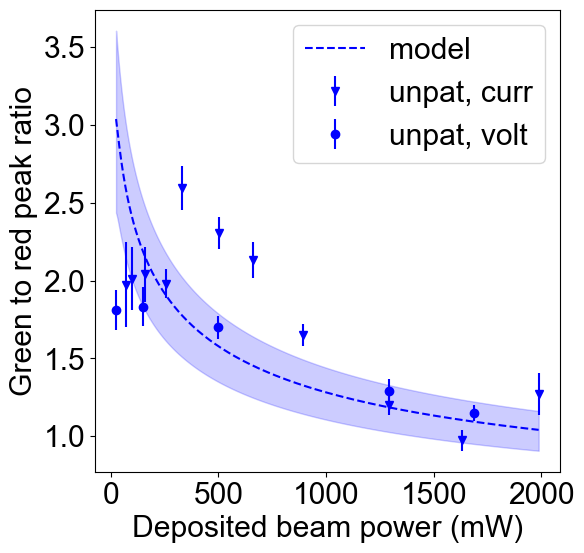

In [12]:
# Plotting full model with uncertainty (unpatterned)
stdvec = [0.,0.,stderror(fit_bounds_unpat)[3]]

plot(sort(x_unpat_plot), model(sort(x_unpat_plot), fit_bounds_unpat.param), "--", label = "model", color = "blue")
errorbar(y_unpat_curr[4].*y_unpat_curr[3].*ene_loss_ratio(y_unpat_curr[4]), y_unpat_curr[1], yerr=y_unpat_curr[2], fmt="v", label = "unpat, curr", color = "blue");
errorbar(y_unpat_volt[4].*y_unpat_volt[3].*ene_loss_ratio(y_unpat_volt[4]), y_unpat_volt[1], yerr=y_unpat_volt[2], fmt="o", label = "unpat, volt", color = "blue");
l = model(sort(x_unpat_plot), fit_bounds_unpat.param.-stdvec)
u = model(sort(x_unpat_plot), fit_bounds_unpat.param.+stdvec)
fill_between(sort(x_unpat_plot), l, u, alpha = 0.2, color = "blue")
legend()
xlabel("Deposited beam power (mW)")
ylabel("Green to red peak ratio");

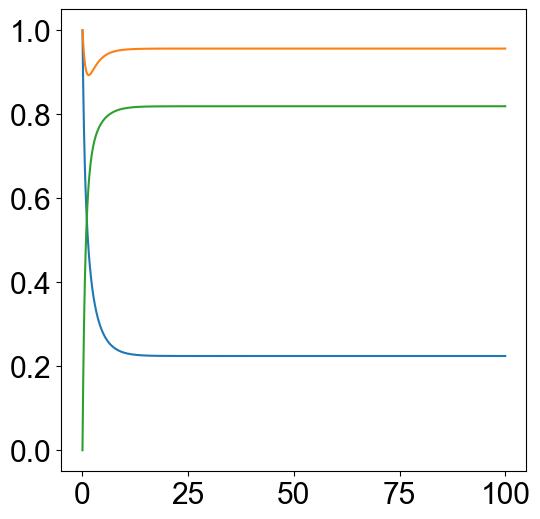

In [13]:
# Check time convergence of solver 
x_test = x_unpat[1]
_, t_test, u_test = model(x_test, fit_bounds_unpat.param, true)

# x_test = xdata_thick4[end]
# _, t_test, u_test = model(x_test, fit_bounds_thick4.param, true)
plot(t_test, u_test);

In [14]:
function evaluate_method(fit, x, title)
    p1, p2, p3 = fit.param
    margin_of_error = margin_error(fit)
    confidence_intervals = confidence_interval(fit)
    std_error = stderror(fit)
    rates_min = [p2*p3*minimum(x),p1,p2*minimum(x),1.]
    rates_max = [p2*p3*maximum(x),p1,p2*maximum(x),1.]
    print(title, " \n")    
    @printf("Γ32 = 1., Γ31 = Γ32*%.2e, Γ13 = %.2e * deposited energy, Γ23 = %.2e * Γ13 \n", p1, p2, p3)
    @printf("fit parameters: %.2e, %.2e, %.2e \n", p1, p2, p3)
    print("error: \n")
    map(x -> @printf("%.2e  ",x), std_error)
    print("\n error (%): \n")    
    map(x -> @printf("%.2e  ",x), std_error./fit.param*100)    
    print("\n Min. rates : \n ")    
    print("[ Γ13 , Γ31, Γ23, Γ32] \n [")
    map(x -> @printf("%.2e  ",x), rates_min)
    print("] \n  Max. rates : \n")    
    print("[ Γ13 , Γ31, Γ23, Γ32] \n [")
    map(x -> @printf("%.2e  ",x), rates_max)    
    print("] \n \n")        
end;
evaluate_method(fit_bounds_unpat, x_unpat, "Experimental uncertainty")

Experimental uncertainty 
Γ32 = 1., Γ31 = Γ32*5.84e-02, Γ13 = 1.04e-04 * deposited energy, Γ23 = 4.43e+00 * Γ13 
fit parameters: 5.84e-02, 1.04e-04, 4.43e+00 
error: 
1.03e-01  1.99e-04  9.41e-01  
 error (%): 
1.76e+02  1.92e+02  2.12e+01  
 Min. rates : 
 [ Γ13 , Γ31, Γ23, Γ32] 
 [1.12e-02  5.84e-02  2.54e-03  1.00e+00  ] 
  Max. rates : 
[ Γ13 , Γ31, Γ23, Γ32] 
 [9.14e-01  5.84e-02  2.06e-01  1.00e+00  ] 
 


# Patterned data

In [15]:
p_unpat = fit_bounds_unpat.param # Take the one that has the lowest uncertainty

lb = [0.001, 0.00001, 0.1]
ub = [10., 0.1,50.0]
p0_bounds = [p_unpat[1]/5, p_unpat[2], p_unpat[3]]

wt = 1 ./ yerr_thick4

fit_bounds_thick4_00 = curve_fit(model, x_thick4, y_thick4, p0_bounds, lower=lb, upper=ub)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.01314586347938505, 0.00020165545740652554, 4.479638959340518], [0.0705790016421608, 0.0908284284542048, 0.011605054305025342, -0.026131764988503225, -0.036130482855122326, -0.005750852491245517, 0.0540194702391692, 0.10947975851603209, 0.19480566429340118, 0.13465100612818381  …  0.11546922534862014, 0.10575583062084881, 0.02164376212429686, 0.1059401721247264, -0.1266032822009897, -0.29909406415312567, -0.40562357217526757, -0.4768802865709534, -0.3039204123688636, 0.00360017086282316], [19.460410553053073 -993.1217371451609 0.19242233683626078; 25.949328437302345 -1493.924953018991 0.12454752717890451; … ; 20.106705693802155 -1085.4588152523763 0.03487971502162178; 20.312463503980215 -1060.6839568106163 0.05085591532006674], true, Float64[])

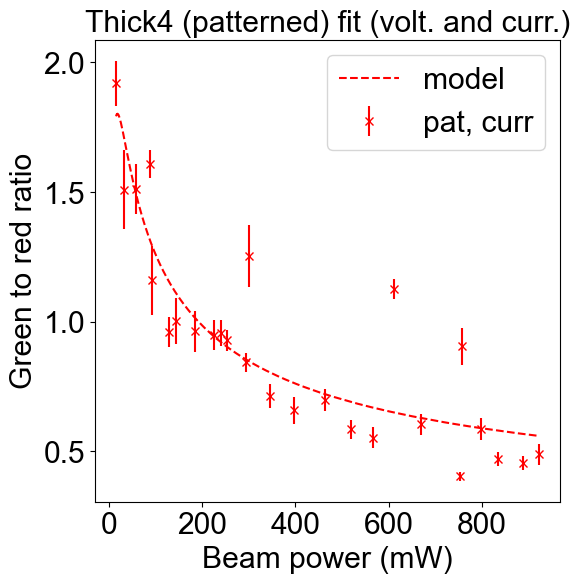

In [16]:
xdata_thick4_plot = [minimum(x_thick4):0.5:maximum(x_thick4);]
param_plot = fit_bounds_thick4_00.param
plot(sort(xdata_thick4_plot), model(sort(xdata_thick4_plot), param_plot), "--", label = "model", color = "red")
errorbar(x_thick4, y_thick4, yerr = yerr_thick4, fmt="x", label = "pat, curr", color = "red");
xlabel("Beam power (mW)")
ylabel("Green to red ratio")
title("Thick4 (patterned) fit (volt. and curr.)")
legend();

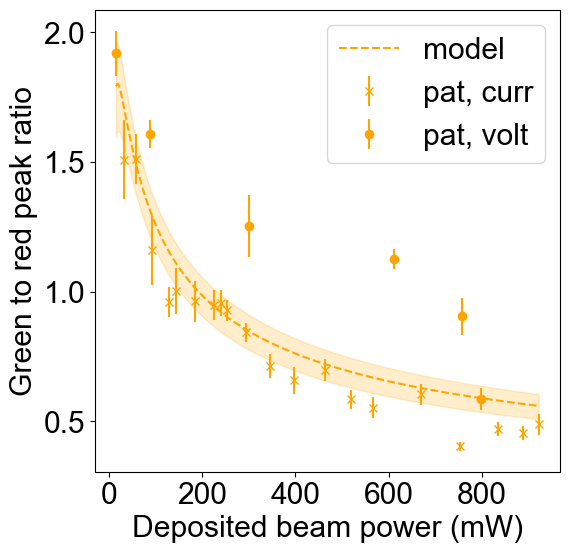

In [17]:
stdvec = [stderror(fit_bounds_thick4_00)[1],0.,0.]

plot(sort(xdata_thick4_plot), model(sort(xdata_thick4_plot), param_plot), "--", label = "model", color = "orange")
errorbar(y_thick4_curr[4].*y_thick4_curr[3].*ene_loss_ratio(y_thick4_curr[4]), y_thick4_curr[1], yerr=y_thick4_curr[2], fmt="x", label = "pat, curr", color = "orange");
errorbar(y_thick4_volt[4].*y_thick4_volt[3].*ene_loss_ratio(y_thick4_volt[4]), y_thick4_volt[1], yerr=y_thick4_volt[2], fmt="o", label = "pat, volt", color = "orange");
l = model(sort(xdata_thick4_plot), fit_bounds_thick4_00.param.-stdvec)
u = model(sort(xdata_thick4_plot), fit_bounds_thick4_00.param.+stdvec)
fill_between(sort(xdata_thick4_plot), l, u, alpha = 0.2, color = "orange")
legend()
xlabel("Deposited beam power (mW)")
ylabel("Green to red peak ratio");

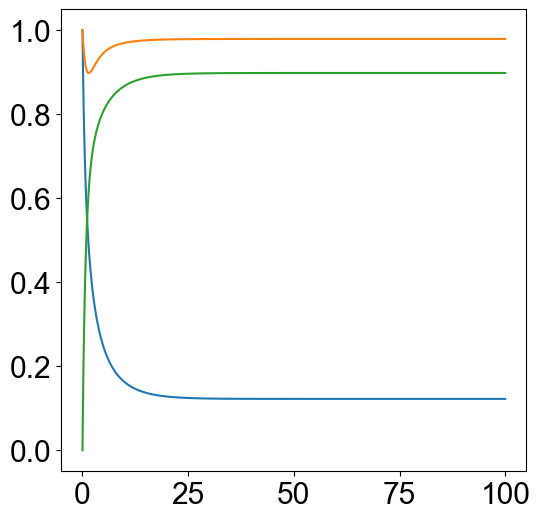

In [18]:
# Check time convergence of solver 
x_test = x_thick4[1]
_, t_test, u_test = model(x_test, fit_bounds_thick4_00.param, true)
plot(t_test, u_test);

In [19]:
evaluate_method(fit_bounds_thick4_00, x_thick4, "Experimental uncertainty, unclamped")

Experimental uncertainty, unclamped 
Γ32 = 1., Γ31 = Γ32*1.31e-02, Γ13 = 2.02e-04 * deposited energy, Γ23 = 4.48e+00 * Γ13 
fit parameters: 1.31e-02, 2.02e-04, 4.48e+00 
error: 
2.47e-03  5.43e-05  8.76e-02  
 error (%): 
1.88e+01  2.69e+01  1.95e+00  
 Min. rates : 
 [ Γ13 , Γ31, Γ23, Γ32] 
 [1.36e-02  1.31e-02  3.04e-03  1.00e+00  ] 
  Max. rates : 
[ Γ13 , Γ31, Γ23, Γ32] 
 [8.33e-01  1.31e-02  1.86e-01  1.00e+00  ] 
 


In [20]:
# ratio1 = p[1] # green to red
# scaling = p[2] # pump scaling
# scaling_ratio = p[3] # pump ratio (green to red)

# Γ32_0 = 1. # excited to red 
# Γ31_0 = Γ32_0*ratio1 # excited to green 
function fit_comparison(fit_unpat, fit_pat)
    p1_thick4, p2_thick4, p3_thick4 = fit_pat.param
    p1_unpat, p2_unpat, p3_unpat = fit_unpat.param
    enhancement = p1_thick4/p1_unpat # enhancement is defined as green to red. Take inverse for rationale (red is enhanced so that 1/enhancement > 1)
    current_scaling_ratio = p2_thick4/p2_unpat
    current_scaling_ratio_ratio = p3_thick4/p3_unpat
    @printf("Patterned to unpatterned (red to green) Γ32 / Γ31 enhancement = %.2e \n", 1/enhancement)
    @printf("Patterned to unpatterned current scaling ratio = %.2e \n", current_scaling_ratio)        
    @printf("Patterned to unpatterned  (green pump to red pump) Γ13 / Γ23 enhancement = %.2e \n", current_scaling_ratio_ratio)        
    print("\n \n")            
end;

In [21]:
# Analysis of the fits:
fit_unpat = fit_bounds_unpat
evaluate_method(fit_bounds_thick4_00, x_thick4, "Experimental uncertainty, unclamped (Tsit5)")
fit_comparison(fit_unpat, fit_bounds_thick4_00)

Experimental uncertainty, unclamped (Tsit5) 
Γ32 = 1., Γ31 = Γ32*1.31e-02, Γ13 = 2.02e-04 * deposited energy, Γ23 = 4.48e+00 * Γ13 
fit parameters: 1.31e-02, 2.02e-04, 4.48e+00 
error: 
2.47e-03  5.43e-05  8.76e-02  
 error (%): 
1.88e+01  2.69e+01  1.95e+00  
 Min. rates : 
 [ Γ13 , Γ31, Γ23, Γ32] 
 [1.36e-02  1.31e-02  3.04e-03  1.00e+00  ] 
  Max. rates : 
[ Γ13 , Γ31, Γ23, Γ32] 
 [8.33e-01  1.31e-02  1.86e-01  1.00e+00  ] 
 
Patterned to unpatterned (red to green) Γ32 / Γ31 enhancement = 4.44e+00 
Patterned to unpatterned current scaling ratio = 1.94e+00 
Patterned to unpatterned  (green pump to red pump) Γ13 / Γ23 enhancement = 1.01e+00 

 
